In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *

from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

# Single scan, WITHOUT TT correction

In [2]:
fc = FileChooser('/sf/alvra/data/p19637/raw')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19637/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
flag = False

Timezero_mm = 21.4

try:
    flag = True
    Timezero_mm = get_timezero_NBS(fc.selected)
except:
    Timezero_mm = Timezero_mm
    
(DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
 DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, 
 Izero_pump, Izero_unpump, correlation1, correlation2, Delay_mm, Delay_fs, goodshots1, goodshots2) = \
XAS_delayscan_noTT_2diodes(fc.selected, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)
        
print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

if scan.parameters['units'] == ['nS']:
    Delay_fs = - scan.values
#    Delay_fs = Delay_fs - 0.17
else:
    Delay_fs = scan.values
    Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)


Processing: run0297-TimeScan_O_IDTBR2_2mgml
Step 90 of 90: Processing acq0090

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
(123,) shots out of (500,) survived
(127,) shots out of (500,) survived
Step 90 of 90: Processed acq0090
correlation Diode1 (all shots) = 0.9896573858275722
correlation Diode2 (all shots) = 0.9741679238715966
------------------------------
Timezero found in file = 21.659920000044984 mm


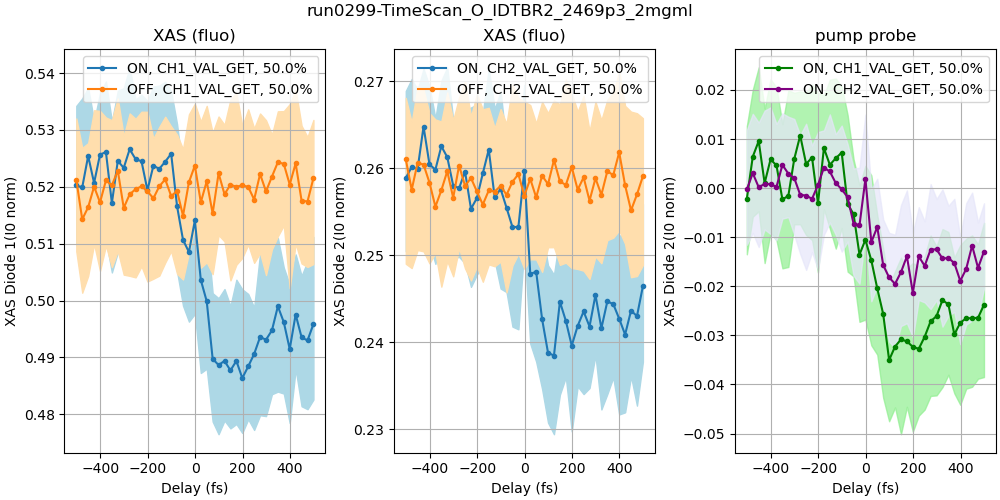

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3], fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS1_pump = DataDiode1_pump[:,0]
err1_low_pump = DataDiode1_pump[:,1]
err1_high_pump = DataDiode1_pump[:,2]
XAS1_unpump = DataDiode1_unpump[:,0]
err1_low_unpump = DataDiode1_unpump[:,1]
err1_high_unpump = DataDiode1_unpump[:,2]
XAS1_pump_probe = Pump_probe_Diode1[:,0]
err1_low_pump_probe = Pump_probe_Diode1[:,1]
err1_high_pump_probe = Pump_probe_Diode1[:,2]

XAS2_pump = DataDiode2_pump[:,0]
err2_low_pump = DataDiode2_pump[:,1]
err2_high_pump = DataDiode2_pump[:,2]
XAS2_unpump = DataDiode2_unpump[:,0]
err2_low_unpump = DataDiode2_unpump[:,1]
err2_high_unpump = DataDiode2_unpump[:,2]
XAS2_pump_probe = Pump_probe_Diode2[:,0]
err2_low_pump_probe = Pump_probe_Diode2[:,1]
err2_high_pump_probe = Pump_probe_Diode2[:,2]

ax1.plot(Delay_fs, XAS1_pump, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS1_unpump, label='OFF, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS2_pump, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Delay_fs, XAS2_unpump, label='OFF, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("XAS Diode 2(I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax3.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
ax3.fill_between(Delay_fs, err1_low_pump_probe, err1_high_pump_probe, alpha = 0.7, color='lightgreen')

ax3.plot(Delay_fs, XAS2_pump_probe, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),color='purple',marker='.')
ax3.fill_between(Delay_fs, err2_low_pump_probe, err2_high_pump_probe, alpha = 0.7, color='lavender')

ax3.set_xlabel("Delay (fs)")
ax3.set_ylabel ("XAS Diode 2(I0 norm)")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

# ax1.set_ylim(1.068, 1.10)
# ax2.set_ylim(0.985, 1.015)
# ax3.set_ylim(-0.005, 0.02)
# for ax in [ax1, ax2, ax3]:
#     ax.set_xlim(-3000, 10000)

plt.show()

#print(Delay_fs[0],Delay_fs[-1])

In [203]:
#### CH1 ####
XAS1_pump      = DataDiode1_pump[:,0]
err1_low_pump  = (DataDiode1_pump[:,1]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)
err1_high_pump = (DataDiode1_pump[:,2]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)

XAS1_unpump      = DataDiode1_unpump[:,0]
err1_low_unpump  = (DataDiode1_unpump[:,1]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)
err1_high_unpump = (DataDiode1_unpump[:,2]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)

XAS1_pump_probe       = Pump_probe_Diode1[:,0]
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = DataDiode2_pump[:,0]
err2_low_pump    = (DataDiode2_pump[:,1]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)
err2_high_pump   = (DataDiode2_pump[:,2]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)

XAS2_unpump      = DataDiode2_unpump[:,0]
err2_low_unpump  = (DataDiode2_unpump[:,1]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)
err2_high_unpump = (DataDiode2_unpump[:,2]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)

XAS2_pump_probe       = Pump_probe_Diode2[:,0]
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

# Averaging 2 diodes

In [204]:
XAS_mean_pump = (XAS1_pump+XAS2_pump)/2
XAS_mean_unpump = (XAS1_unpump+XAS2_unpump)/2

offset1 = np.average(XAS1_unpump[0:5])
offset2 = np.average(XAS2_unpump[0:5])

ave_unpump = (XAS1_unpump-offset1 + XAS2_unpump-offset2)/2
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-offset1 + XAS2_pump-offset2)/2
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

##Average first, subtract later
ave_pp1 = ave_pump - ave_unpump
#ave_pp_err1 = np.sqrt((ave_unpump_err_h-ave_unpump_err_l)**2+np.square(ave_pump_err_h-ave_pump_err_l)**2)
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

##Average of the difference signals
factor = 1
ave_pp2 = (XAS1_pump_probe*factor + XAS2_pump_probe*factor)/2
ave_pp_err_l2 = ((err1_low_pump_probe + err2_low_pump_probe)/2)*factor
ave_pp_err_h2 = ((err1_high_pump_probe + err2_high_pump_probe)/2)*factor

# Plotting Averged Diodes with error bars

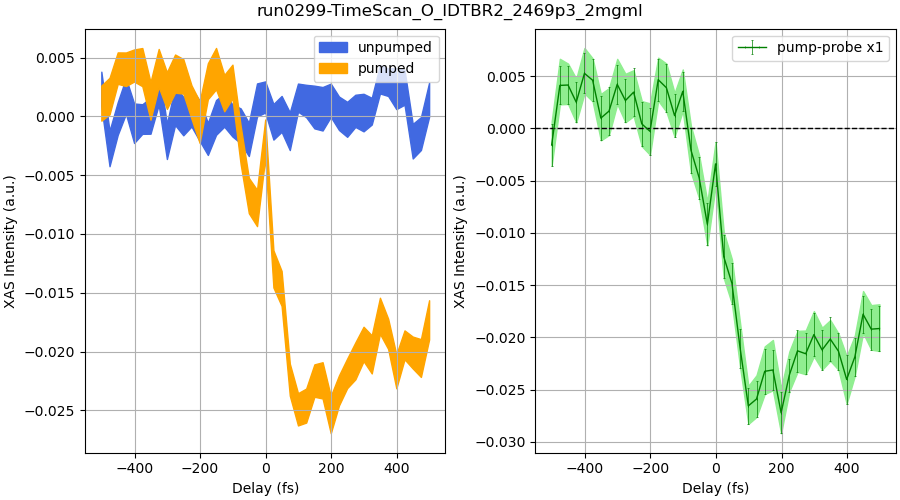

In [205]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3], fontsize = 12)


# ax1.axes.errorbar(Delay_fs,ave_unpump, ave_unpump_err_l ,ave_unpump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='unpumped')
# ax1.axes.errorbar(Delay_fs, ave_pump,  ave_pump_err_l,  ave_pump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='pumped')

#ax1.plot(Delay_fs,ave_unpump,lw=1,marker='o',markersize=3,label='unpumped')
ax1.fill_between(Delay_fs,ave_unpump-ave_unpump_err_l, ave_unpump+ave_unpump_err_h,color='royalblue',label='unpumped')
ax1.fill_between(Delay_fs,ave_pump-ave_pump_err_l, ave_pump+ave_pump_err_h,color='orange',label='pumped')


ax1.set_xlabel('Delay (fs)')
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.legend()
#ax1.set_xlim(-400,900)

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Delay_fs, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pump-probe x{}'.format(factor))
#ax2.plot(Delay_fs,ave_pp1,lw=1,marker='o',markersize=3,color='green',label='unpumped')
ax2.fill_between(Delay_fs,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel('Delay (fs)')
ax2.set_ylabel('XAS Intensity (a.u.)')
ax2.grid()
ax2.legend()
#ax2.set_xlim(-400,400)


## Average of the differences
# ax2.axes.errorbar(Delay_fs, ave_pp2, ave_pp_err_l2, ave_pp_err_h2, 
#              lw=1,marker='o', markersize=2,capsize=2,label='pump-probe x{}'.format(factor))
# ax2.axhline(0,ls='--',c='k',lw=1)
# ax2.set_xlabel('Delay (fs)')
# ax2.set_ylabel('XAS Intensity (a.u.)')
# ax2.legend()
# ax2.set_ylim(-0.03,0.1)


In [206]:
reducedir = '../Claudio/Reduced/'
os.makedirs(reducedir, exist_ok=True)
run_name = fc.selected.split('/')[-3]

title = 'Delay (fs), pumpprobe, error_low, error_high'
array = np.transpose(np.array([Delay_fs, 
                               ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
                              ]))
np.savetxt(reducedir+run_name+'.txt', array, header=title)

In [158]:
datafiles = []
for file in glob('/das/work/p19/p19637/Claudio/Reduced/*timescan_O*.txt'):
    datafiles.append(file)
datafiles = sorted(datafiles)#, key = os.path.getmtime)
patch = datafiles[-3:]
patch

['/das/work/p19/p19637/Claudio/Reduced/run0225-timescan_O_IDTBR2_2469p3.txt',
 '/das/work/p19/p19637/Claudio/Reduced/run0230-timescan_O_IDTBR2_2469p3.txt',
 '/das/work/p19/p19637/Claudio/Reduced/run0232-timescan_O_IDTBR2_2469p3.txt']

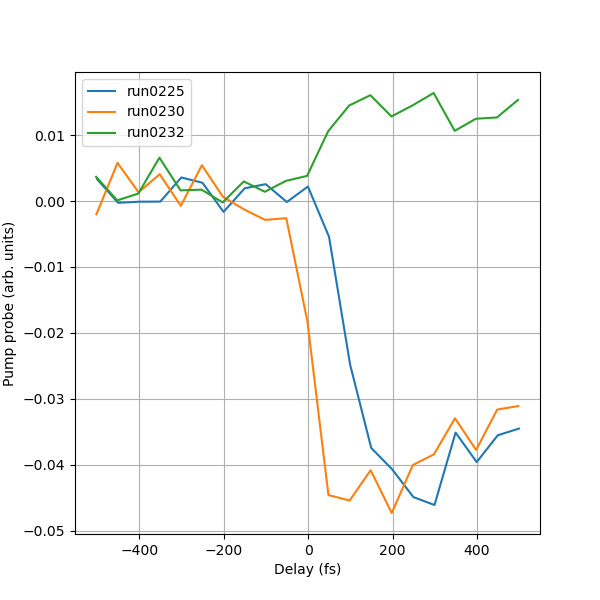

In [159]:
plt.figure(figsize=(6,6))
for index in range(len(patch)):
    label = patch[index].split('/')[-1]
    Del = np.transpose(np.genfromtxt(patch[index]))[0]
    Int = np.transpose(np.genfromtxt(patch[index]))[1]
    plt.plot(Del, Int, label = label.split('-')[0])#.split('_')[-1])
plt.legend(loc='best')
plt.xlabel('Delay (fs)')
plt.ylabel('Pump probe (arb. units)')
plt.grid()
plt.show()
plt.tight_layout()

In [187]:
from scipy.optimize import curve_fit

def exp_gauss_heaviside(x,x0,amplitude,width,offset,lifetime):
    sigma = width/2./np.sqrt(2*np.log(2))
    frac1 = (sigma**2-2*lifetime*(x-x0))/2./lifetime**2
    frac2 = (sigma**2 - lifetime*(x-x0))/np.sqrt(2)/sigma/lifetime
    return amplitude*0.5*np.exp(frac1)*(1-erf(frac2)) + offset

In [207]:
# conv_exp_gauss_heaviside(x,x0,amplitude,width,offset,lifetime)
# conv_exp_gauss_heaviside2(x,x0,amplitude,width,offset,lifetime,a,b)

popt, pcov = curve_fit(exp_gauss_heaviside, Delay_fs, ave_pp1, p0 = [150, 0.05, 150, -0.001, 10000])

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, ave_pp1)            # this sets some internal params 
# fit.p0 = better_p0(fit.p0, 0, 200) # overwrite some values (index) if needed:
#fit.p0 = better_p0(fit.p0, 1, 0.01) # overwrite some values (index) if needed:
# fit.p0 = better_p0(fit.p0, 2, 200) # overwrite some values (index) if needed:
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_fs,ave_pp1)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
width_fs = fit.popt[2]

t0_fs = popt[0]
width_fs = popt[2]

print("Width = {:.2f} fs".format(np.abs(width_fs)))
print("t0 = {:.2f} fs".format(t0_fs))
#print('\nLifetime = {:.0f} fs'.format(popt[-1]))
# print(popt)

Width = 141.78 fs
t0 = 0.91 fs


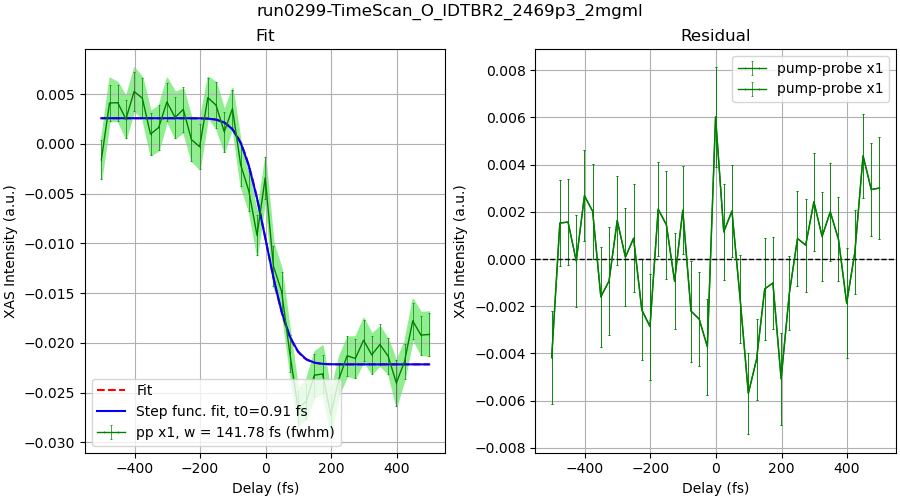

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3], fontsize = 12)

ax1.axes.errorbar(Delay_fs, ave_pp1, ave_pp_err_l1, ave_pp_err_h1, 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pp x{}, w = {:.2f} fs (fwhm)'.format(factor,np.abs(width_fs)))
ax1.fill_between(Delay_fs,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax1.plot(np.linspace(Delay_fs[0], Delay_fs[-1], 1000), 
         exp_gauss_heaviside(np.linspace(Delay_fs[0], Delay_fs[-1], 1000), *popt ), 
         'r--', label = 'Fit')

ax1.plot(Delay_fs, pp_fit, color = 'blue', label = 'Step func. fit, t0={:.2f} fs'.format(t0_fs))
ax1.set_xlabel('Delay (fs)')
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.set_title('Fit')
ax1.legend()
ax1.grid()
#ax1.set_xlim(7110,7150)

# Difference of the Averages (probably more correct)
ax2.axes.errorbar(Delay_fs, ave_pp1 - pp_fit, ave_pp_err_l1, ave_pp_err_h1, 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pump-probe x{}'.format(factor))

ax2.axes.errorbar(Delay_fs, ave_pp1 - exp_gauss_heaviside(Delay_fs, *popt), ave_pp_err_l1, ave_pp_err_h1, 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pump-probe x{}'.format(factor))

#ax2.plot(Delay_fs,ave_pp1,lw=1,marker='o',markersize=3,color='green',label='unpumped')
#ax2.fill_between(Delay_fs,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel('Delay (fs)')
ax2.set_ylabel('XAS Intensity (a.u.)')
ax2.set_title('Residual')
ax2.grid()
ax2.legend()

In [1187]:
from scipy.special import erf
from scipy.optimize import curve_fit

def model_decay_2exp(t, t0, amp1, amp2, amp3, tau1, tau2, sigma, offset):
    return  0.5*(amp1 * np.exp((t0-t)/tau1 + 0.5*(sigma/tau1)**2)) * (1 + erf((t-(t0+sigma**2/tau1))/sigma*np.sqrt(2))) +\
            0.5*(amp2 * np.exp((t0-t)/tau2 + 0.5*(sigma/tau2)**2)) * (1 + erf((t-(t0+sigma**2/tau2))/sigma*np.sqrt(2))) +\
            0.5* amp3 * (1 + erf((t-t0)/(sigma*np.sqrt(2)))) + offset

In [1175]:
print (XAS_pump_probe.max(), XAS_pump_probe.max(), XAS_pump_probe.max(), Delay_fs.mean()/2, Delay_fs.mean(), np.diff(Delay_fs).mean(), XAS_pump_probe.min())

0.004155056836014984 0.004155056836014984 0.004155056836014984 992.0002307618657 1984.0004615237315 230.3370786516854 -0.03215121230899945


In [1127]:
XAS_pump_probe = (XAS1_pump_probe + XAS2_pump_probe)/2
XAS_err_l=np.sqrt(err1_low_pump_probe**2+err2_low_pump_probe**2)
XAS_err_h=np.sqrt(err1_high_pump_probe**2+err2_high_pump_probe**2)
XAS_errobar_l=(XAS_pump_probe-XAS_err_l)/np.sqrt(goodsho)
XAS_errobar_h=(XAS_err_h-XAS_pump_probe)/np.sqrt(16)

parameters,_ = curve_fit(model_decay_2exp, Delay_fs, XAS_pump_probe, p0 = [100, 0.08, 0.01, 0.015, 2000, 1000, 200, 0.0])
#parameters,_ = curve_fit(model_decay_2exp, Delay_fs, XAS_pump_probe, p0 = [-100, XAS_pump_probe.max(), XAS_pump_probe.max()/2, XAS_pump_probe.max()/2, Delay_fs.mean()/2, Delay_fs.mean(), np.diff(Delay_fs).mean(), XAS_pump_probe.min()])
plt.figure()
plt.title(fc.selected.split('/')[-3], fontsize = 12)
plt.plot(Delay_fs, XAS_pump_probe, 'o')
plt.errorbar(Delay_fs, XAS_pump_probe, XAS_errobar_l, XAS_errobar_h, 
             lw=0,color='k', marker='o', markersize=4,capsize=3,capthick=1,
                  ecolor='k',elinewidth=1,label='pump-probe')
plt.plot(Delay_fs, model_decay_2exp(Delay_fs,*parameters), color='r')
plt.grid()
plt.show()
print ("t0 = {} fs".format(parameters[0]))
print ("tau1 = {} fs".format(parameters[4]))
print ("tau2 = {} fs".format(parameters[5]))
print ("width = {} fs".format(parameters[6]))


NameError: name 'goodsho' is not defined

In [1128]:
XAS_pump_probe = (XAS1_pump_probe + XAS2_pump_probe)/2

# fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)

fit.estimate(Delay_fs, XAS_pump_probe)            # this sets some internal params 
# fit.p0 = better_p0(fit.p0, 0, -50) # overwrite some values (index) if needed: 
# fit.p0 = better_p0(fit.p0, 4, 300) # overwrite some values (index) if needed:
# fit.p0 = better_p0(fit.p0, 5, 1e-3) # overwrite some values (index) if needed:
# fit.p0 = better_p0(fit.p0, 6, 0.07) # overwrite some values (index) if needed:

print (fit.p0)

fit.fit(Delay_fs,XAS_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting
t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print (fit.popt)

plt.figure()
plt.plot(Delay_fs, XAS_pump_probe, '.')
plt.plot(Delay_fs, pp_fit)
plt.grid()
plt.show()

print (t0_fs)

(-55.37163980293553, 0.004155056836014984, 50.0, -0.03215121230899945)


ValueError: operands could not be broadcast together with shapes (21,) (18,) 

## Check correlation for a certain delay point

In [1129]:
chosen_delay_fs = 8000

detector_XAS = channel_diode_1
detector_Izero = channel_Izero117

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

IndexError: index 0 is out of bounds for axis 0 with size 0

NameError: name 'index_delay' is not defined

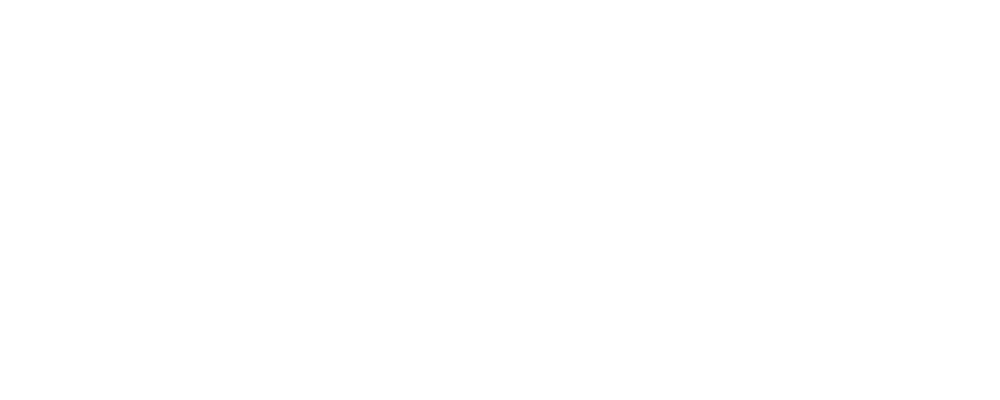

In [1130]:
plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(fc.selected.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump_filter, Fluo_pump_filter)
plt.scatter(Izero_pump, Fluo_pump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter)
plt.scatter(Izero_unpump, Fluo_unpump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

# Loop of scans, WITHOUT TT correction

In [1108]:
datafiles = []
for file in glob('/sf/alvra/data/p19262/raw/scan_info/*timescan_CpRhCO2_3002p8eV*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:-1]
patch

['/sf/alvra/data/p19262/raw/scan_info/067_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/073_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/083_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/089_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/098_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/099_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/102_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/105_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/108_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/109_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/110_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/113_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/138_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/r

In [1109]:
quantile_corr = 0.6
Timezero_mm = 86.61422    ## this in mm from the YAG scans

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode_pump_all = []
DataDiode_unpump_all = []
Pump_probe_all = []
Delay_fs_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    
    DataDiode_pump = []
    DataDiode_unpump = []
    Pump_probe_Diode = []
    
    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
     Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs) = \
    XAS_delayscan_noTT(json_file, detector_XAS, detector_Izero, quantile_corr)
    
    DataDiode_pump_all.append(DataDiode_pump)
    DataDiode_unpump_all.append(DataDiode_unpump)
    Pump_probe_all.append(Pump_probe_Diode)

    Delay_fs_all.append(Delay_fs - mm2fs(Timezero_mm, 0))

DataDiode_pump_all = np.array(DataDiode_pump_all)
DataDiode_unpump_all = np.array(DataDiode_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)


Processing: raw
Step 23 of 55: Processing run_004569

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1403 / 1403 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1403 / 1403 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1403 / 1403 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1403 / 1403 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 701 pump and 701 unpump shots
(252,) shots out of (701,) survived
Step 23 of 55: Processed run_004569
correlation Diode (all shots) = 0.9913082831018033


KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = (XAS_pump - np.mean(DataDiode_pump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_pump = (np.mean(DataDiode_pump_all, axis=0)[:,2]-XAS_pump)/np.sqrt(len(patch))
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = (XAS_unpump - np.mean(DataDiode_unpump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_unpump = (np.mean(DataDiode_unpump_all, axis =0)[:,2]-XAS_unpump)/np.sqrt(len(patch))
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]#/np.sqrt(len(patch))
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]#/np.sqrt(len(patch))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()